## Two regularisation methods

In [2]:
# recon_pair.py  ─── run “python recon_pair.py”
import torch, deepinv as dinv
from pathlib import Path
import matplotlib.pyplot as plt

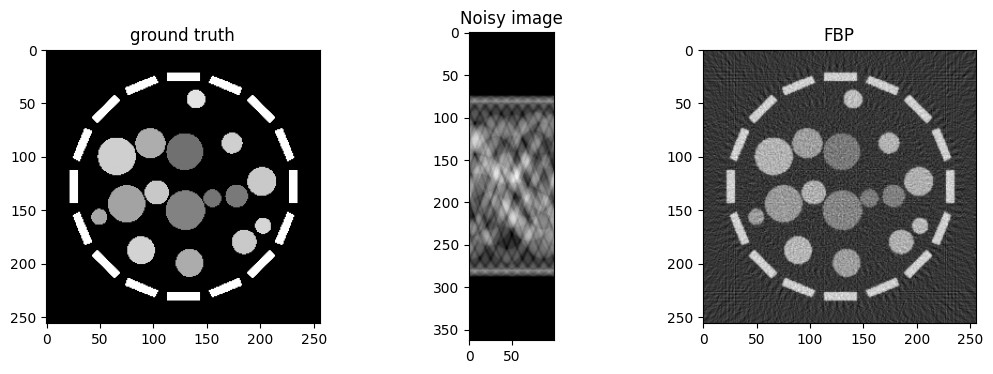

fbp tensor([[[[-0.0243, -0.0062,  0.0257,  ..., -0.0007,  0.0754, -0.0068],
          [-0.0458, -0.0161, -0.0104,  ..., -0.0421,  0.0004,  0.0284],
          [ 0.0155,  0.0374,  0.0348,  ..., -0.1088,  0.0773,  0.0318],
          ...,
          [-0.0367, -0.0787, -0.1182,  ...,  0.0558,  0.0413,  0.0159],
          [ 0.0049,  0.0124,  0.0523,  ..., -0.0645,  0.1593,  0.0439],
          [ 0.0599,  0.0290, -0.0323,  ..., -0.0724, -0.0655,  0.0963]]]],
       device='cuda:0')
x_gt: nan? False inf? False all zero? False
y:    nan? False inf? False all zero? False


In [7]:
from skimage.data import shepp_logan_phantom
from skimage.transform import resize
import numpy as np


# ── parameters ───────────────────────────────
IMG_SZ, ANGLES, GAIN      = 128, 100, 1/40          # physics
DEVICE                    = "cuda" if torch.cuda.is_available() else "cpu"

# Load the shepp logan phantom
# Load and convert to torch tensor with correct size and device
phantom = shepp_logan_phantom()
phantom_resized = resize(phantom, (IMG_SZ, IMG_SZ), mode='reflect', anti_aliasing=True)

# load created phantom
phantoms = np.load("data/phantoms.npy", allow_pickle=True)
IMG_SZ = phantoms[0].shape[0]
phantom_resized = phantoms[0]

x_gt = torch.from_numpy(phantom_resized.astype(np.float32)).to(DEVICE)
x_gt = x_gt.unsqueeze(0).unsqueeze(0)  # add batch and channel dimensions

# ── 0. toy phantom  +  Poisson measurements ─────────────────────────
# x_gt  = dinv.utils.demo.load_image("shepp_logan", img_size=IMG_SZ).to(DEVICE)
physics = dinv.physics.Tomography(
    img_width=IMG_SZ, angles=ANGLES, device=DEVICE,
    noise_model=dinv.physics.PoissonNoise(gain=GAIN), verbose=False)

y = physics(x_gt)


# Try a simple reconstruction FBP
# ── 1. FBP reconstruction ───────────────────────────────
fbp = physics.A_dagger(y)

# ── plot the ground truth and the corrupted image.
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.imshow(x_gt.cpu()[0,0,:,:], cmap = 'gray')
plt.title("ground truth")

plt.subplot(132)
plt.imshow(y.cpu()[0,0,:,:], cmap = 'gray')
plt.title("Noisy image")

plt.subplot(133)
plt.imshow(fbp.cpu()[0,0,:,:], cmap = 'gray')
plt.title("FBP")

plt.show()

print("fbp", fbp)

# Diagnostic: Check for NaNs, Infs, and all-zeros in x_gt and y
print("x_gt: nan?", torch.isnan(x_gt).any().item(), "inf?", torch.isinf(x_gt).any().item(), "all zero?", torch.all(x_gt == 0).item())
print("y:    nan?", torch.isnan(y).any().item(),    "inf?", torch.isinf(y).any().item(),    "all zero?", torch.all(y == 0).item())

100.0
psnr
cost
residual
torch.Size([1, 1, 256, 256])
X_a: tensor([[[[-0.0203,  0.0140,  0.0419,  ..., -0.0085,  0.0455, -0.0197],
          [-0.0357, -0.0114,  0.0059,  ..., -0.0353, -0.0062,  0.0022],
          [ 0.0158,  0.0242,  0.0307,  ..., -0.0850,  0.0442,  0.0110],
          ...,
          [-0.0212, -0.0512, -0.0921,  ...,  0.0265,  0.0208, -0.0103],
          [-0.0005,  0.0007,  0.0336,  ..., -0.0540,  0.1109,  0.0187],
          [ 0.0306, -0.0005, -0.0329,  ..., -0.0661, -0.0633,  0.0523]]]],
       device='cuda:0')
gt: tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]], device='cuda:0')


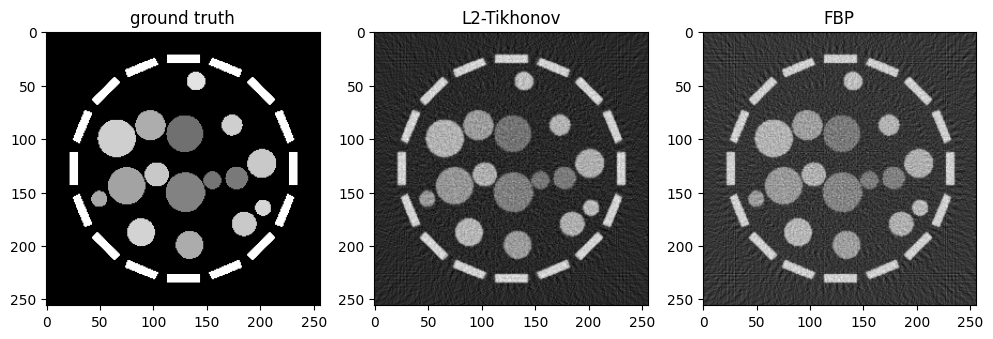

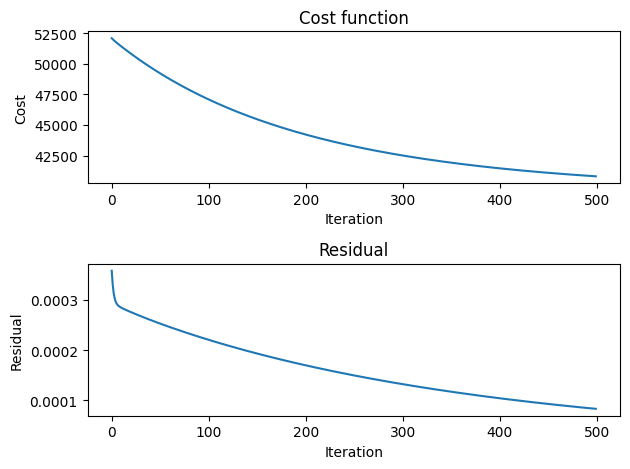

In [ ]:
# ── 1A. L2-Tikhonov  (PGD) ──────────────────────────────────────────
from deepinv.optim import optim_builder
from deepinv.optim.data_fidelity import L2
from deepinv.optim.prior         import Tikhonov

# prior_A = Tikhonov()
prior = Tikhonov()

# Select the data fidelity term
data_fidelity = L2()
print(1e2)
# Specific parameters for restoration with the given prior (Note that these parameters have not been optimized here)
params_algo = {"stepsize": 0.00001, "lambda": 1e1}

# Logging parameters
verbose = True

# Parameters of the algorithm to solve the inverse problem
early_stop = True  # Stop algorithm when convergence criteria is reached
crit_conv = "cost"  # Convergence is reached when the difference of cost function between consecutive iterates is
# smaller than thres_conv
thres_conv = 1e-5 # was 1e-5
backtracking = False  # use backtraking to automatically adjust the stepsize
max_iter = 1000  # Maximum number of iterations


model = optim_builder(
    iteration="GD",
    prior=prior,
    g_first=False,
    data_fidelity=data_fidelity,
    params_algo=params_algo,
    early_stop=early_stop,
    max_iter=max_iter,
    crit_conv=crit_conv,
    thres_conv=thres_conv,
    backtracking=backtracking,
    verbose=verbose,
    custom_init=lambda y, physics: {
        "est": (physics.A_dagger(y), physics.A_dagger(y))
    }
)


# x_A = model(y, physics,x_gt = x_gt, compute_metric = True)
x_A, metrics = model(
    y, physics, x_gt=x_gt, compute_metrics=True
)  # reconstruction with PGD algorithm

for k in metrics:      # or: for k in my_dict.keys()
    print(k)
print(x_A.shape)
print("X_a:",x_A)

print("gt:" ,x_gt)


plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.imshow(x_gt.cpu()[0,0,:,:], cmap = 'gray')
plt.title("ground truth")
plt.subplot(132)
plt.imshow(x_A.cpu()[0,0,:,:], cmap = 'gray')
plt.title("L2-Tikhonov")
plt.subplot(133)
plt.imshow(fbp.cpu()[0,0,:,:], cmap = 'gray')
plt.title("FBP")
plt.show()

plt.figure()
plt.subplot(211)
plt.plot(metrics['cost'][0])
plt.title("Cost function")
plt.xlabel("Iteration")
plt.ylabel("Cost")

plt.subplot(212)
plt.plot(metrics['residual'][0])
plt.title("Residual")
plt.xlabel("Iteration") 
plt.ylabel("Residual")


plt.tight_layout()
plt.show()

## just gradient descent

grad prior tensor(1.0964, device='cuda:0')
grad l2 tensor(12.9993, device='cuda:0')
1863.231689453125
grad prior tensor(1.0979, device='cuda:0')
grad l2 tensor(12.1853, device='cuda:0')
1846.080078125
grad prior tensor(1.0993, device='cuda:0')
grad l2 tensor(11.9790, device='cuda:0')
1829.7012939453125
grad prior tensor(1.1007, device='cuda:0')
grad l2 tensor(11.7594, device='cuda:0')
1813.98779296875
grad prior tensor(1.1021, device='cuda:0')
grad l2 tensor(11.6117, device='cuda:0')
1798.87744140625
grad prior tensor(1.1034, device='cuda:0')
grad l2 tensor(11.4840, device='cuda:0')
1784.3251953125
grad prior tensor(1.1047, device='cuda:0')
grad l2 tensor(11.3719, device='cuda:0')
1770.294189453125
grad prior tensor(1.1059, device='cuda:0')
grad l2 tensor(11.2675, device='cuda:0')
1756.752197265625
grad prior tensor(1.1071, device='cuda:0')
grad l2 tensor(11.1679, device='cuda:0')
1743.6719970703125
grad prior tensor(1.1082, device='cuda:0')
grad l2 tensor(11.0710, device='cuda:0')
173

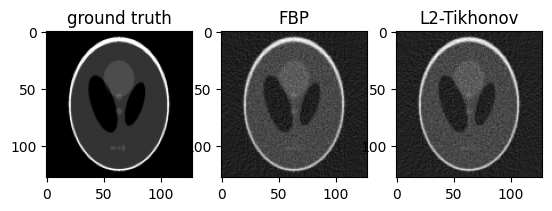

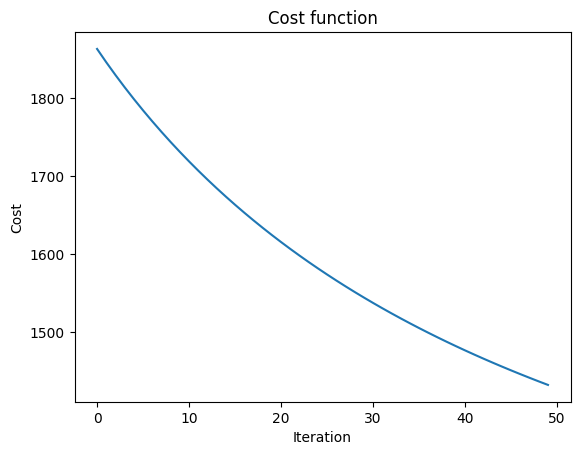

In [211]:
stepsize = 0.0001
max_iter = 50
x_k  = fbp.clone()  # Initialize x_k with the FBP reconstruction
lambd = 1  # Regularization parameter
costs = []
for it in range(max_iter):
    # print(data_fidelity.grad(x_k, y, physics))
    print("grad prior",torch.max(prior.grad(x_k)))
    print("grad l2", torch.max(data_fidelity.grad(x_k, y, physics)))
    x_k = x_k - stepsize*data_fidelity.grad(x_k, y, physics) - stepsize * prior.grad(x_k) # Gradient step
    # print(prior.grad(u))
    # x_k = prior.prox(u, gamma=lambd*stepsize)  # Proximal step
    cost = data_fidelity(x_k, y, physics) + lambd*prior(x_k)  # Compute the cost
    print(cost.item())
    costs.append(cost.item())
plt.figure()
plt.subplot(131)
plt.imshow(x_gt.cpu()[0,0,:,:], cmap = 'gray')
plt.title("ground truth")
plt.subplot(132)
plt.imshow(fbp.cpu()[0,0,:,:], cmap = 'gray')
plt.title("FBP")
plt.subplot(133)
plt.imshow(x_k.cpu()[0,0,:,:], cmap = 'gray')
plt.title("L2-Tikhonov")
plt.show()

plt.figure()
plt.plot(costs)
plt.title("Cost function")
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()


## let us try the poisson likelihood

tensor([[[[-0.3387, -0.3272, -0.3209,  ..., -0.2994, -0.2841, -0.3474],
          [-0.2485, -0.2518, -0.2332,  ..., -0.2407, -0.2735, -0.2658],
          [-0.3194, -0.3619, -0.2790,  ..., -0.2672, -0.3201, -0.3166],
          ...,
          [-0.2109, -0.2664, -0.2696,  ..., -0.2344, -0.6283, -0.3502],
          [-0.2074, -0.2704, -0.2522,  ..., -0.1884, -0.4252, -0.4734],
          [-0.3370, -0.2928, -0.2792,  ..., -0.2933, -0.3898, -0.6495]]]],
       device='cuda:0')
{'psnr': [[25.798398971557617, 25.794050216674805, 25.753944396972656, 25.681991577148438, 25.577552795410156, 25.4486083984375, 25.297372817993164, 25.126426696777344, 24.942546844482422, 24.746944427490234, 22.895357131958008, 22.740734100341797, 22.566856384277344, 21.459360122680664, 21.342693328857422, 21.215850830078125, 21.087495803833008, 20.95690155029297, 20.824020385742188, 20.68911361694336, 20.552513122558594, 20.41455078125, 20.275524139404297, 20.135709762573242, 19.99536895751953, 19.854734420776367, 19.7

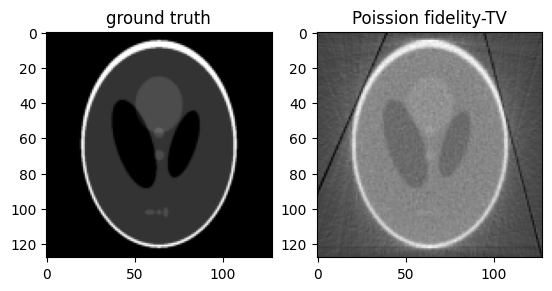

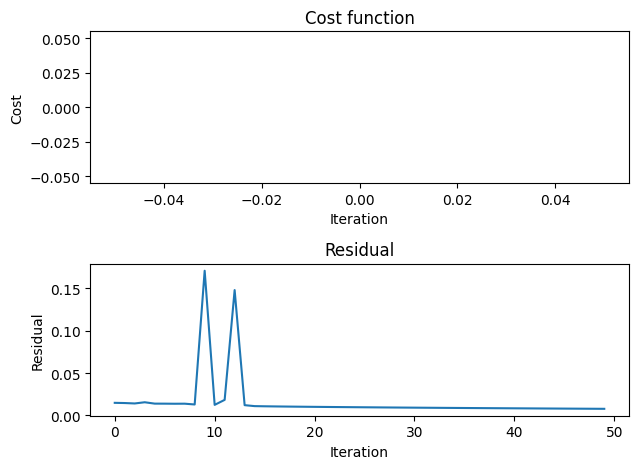

In [246]:
from deepinv.optim.data_fidelity import PoissonLikelihood
from deepinv.optim.prior         import TVPrior, Tikhonov
from deepinv.optim               import optim_builder

GAIN        = 1/40          # same as you used to corrupt y
λ_tv        = 1e-2         # tweak ↑ for sharper / ↓ for smoother
max_iter_B  = 50

prior_B   = TVPrior()
# prior_B = Tikhonov()
fidelityB = PoissonLikelihood(gain=GAIN,bkg=0.00001, denormalize= True)
# fidelityB = L2()
SCALING = 1
model_B = optim_builder(
    iteration="GD",
    prior=prior_B,
    data_fidelity=fidelityB,
    params_algo={"stepsize": 0.005, "lambda": λ_tv},   # PD3O default is usually fine
    max_iter=max_iter_B,
    early_stop=True,
    crit_conv="cost",
    thres_conv=1e-5,
    verbose=True,
    # custom_init=lambda y, physics: {
    #     "est": (physics.A_adjoint(y) * SCALING, physics.A_adjoint(y) * SCALING)
    # }
    custom_init=lambda y, physics: {
        "est": (physics.A_dagger(y), physics.A_dagger(y))
    }
    # custom_init = physics.A_dagger(y)
)

x_B, metrics = model_B(y, physics, x_gt=x_gt, compute_metrics=True)
print(x_B)
print(metrics)

plt.figure()
plt.subplot(121)
plt.imshow(x_gt.cpu()[0,0,:,:], cmap = 'gray')
plt.title("ground truth")
plt.subplot(122)
plt.imshow(x_B.cpu()[0,0,:,:], cmap = 'gray')
plt.title("Poission fidelity-TV")
plt.show()

plt.figure()
plt.subplot(211)
plt.plot(metrics['cost'][0])
plt.title("Cost function")
plt.xlabel("Iteration")
plt.ylabel("Cost")

plt.subplot(212)
plt.plot(metrics['residual'][0])
plt.title("Residual")
plt.xlabel("Iteration") 
plt.ylabel("Residual")
plt.tight_layout()
plt.show()

In [52]:
from deepinv.optim import Prior
# Create a custom prior which inherits from the base Prior class.
class L2Prior(Prior):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.explicit_prior = True

    def fn(self, x, args, **kwargs):
        return 0.5 * torch.norm(x.view(x.shape[0], -1), p=2, dim=-1) ** 2


# Specify the custom prior
prior = Tikhonov()

# Select the data fidelity term
data_fidelity = L2()

# Specific parameters for restoration with the given prior (Note that these parameters have not been optimized here)
params_algo = {"stepsize": 1, "lambda": 0.1}

# Logging parameters
verbose = True

# Parameters of the algorithm to solve the inverse problem
early_stop = True  # Stop algorithm when convergence criteria is reached
crit_conv = "cost"  # Convergence is reached when the difference of cost function between consecutive iterates is
# smaller than thres_conv
thres_conv = 1e-5
backtracking = False  # use backtraking to automatically adjust the stepsize
max_iter = 500  # Maximum number of iterations

# Instantiate the algorithm class to solve the IP problem.
model = optim_builder(
    iteration="ADMM",
    prior=prior,
    g_first=False,
    data_fidelity=data_fidelity,
    params_algo=params_algo,
    early_stop=early_stop,
    max_iter=max_iter,
    crit_conv=crit_conv,
    thres_conv=thres_conv,
    backtracking=backtracking,
    verbose=verbose,
)

Iteration 51, current converge crit. = 7.62E-06, objective = 1.00E-05 
torch.Size([1, 1, 128, 128])
X_a: tensor([[[[-0.0092,  0.0111,  0.0015,  ...,  0.0018,  0.0084, -0.0079],
          [ 0.0005, -0.0093,  0.0253,  ...,  0.0226, -0.0079,  0.0016],
          [ 0.0048, -0.0200,  0.0214,  ...,  0.0213, -0.0185,  0.0045],
          ...,
          [ 0.0045, -0.0101,  0.0137,  ...,  0.0105, -0.0084,  0.0061],
          [ 0.0036, -0.0071,  0.0125,  ...,  0.0112, -0.0105,  0.0042],
          [-0.0033,  0.0011,  0.0042,  ...,  0.0064,  0.0010, -0.0041]]]],
       device='cuda:0')
gt: tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]], device='cuda:0')


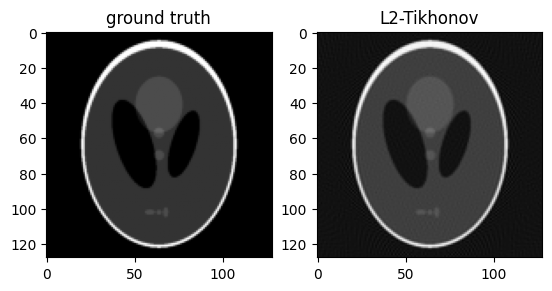

In [53]:

# x_A  = algo_A(y, physics)
x_A = model(y, physics)

print(x_A.shape)
print("X_a:",x_A)

print("gt:" ,x_gt)


plt.figure()
plt.subplot(121)
plt.imshow(x_gt.cpu()[0,0,:,:], cmap = 'gray')
plt.title("ground truth")
plt.subplot(122)
plt.imshow(x_A.cpu()[0,0,:,:], cmap = 'gray')
plt.title("L2-Tikhonov")
plt.show()

In [ ]:
# # ── 1B. Poisson-TV  (PD3O) ──────────────────────────────────────────
# from deepinv.optim.data_fidelity import PoissonLikelihood
# from deepinv.optim.prior         import TVPrior          # needs deepinv ≥0.3
# from deepinv.optim.bregman       import IdentityPotential

# prior_B = TVPrior(weight=LAMBDA_TV)
# algo_B  = optim_builder("PD3O",
#                         data_fidelity=PoissonLikelihood(gain=GAIN),
#                         prior=prior_B,
#                         max_iter=MAXITER_B,
#                         params_algo={"stepsize": 1.0})   # PD3O is robust

# x_B, _  = algo_B(y, physics)

# # ── 2. quick visual sanity check ────────────────────────────────────
# dinv.utils.plotting.plot([y, x_gt, x_A, x_B],
#         titles=["Sinogram", "Ground-truth", "Tikhonov", "Poisson-TV"],
#         save_dir="results", show=True)